In [1]:
import egglib
import glob 
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

Goal: calculate nucleotide diversity per site for maize promoter alignments using the egglib python package 

In [2]:
#write a function that takes in per-clade promoter alignment and outputs desired statistics 
directory='/global/scratch/projects/vector_kvklab/promoter_alignment/'
def whole_aln(clade, max_missing):
    #load alignment, and subset by domain
    #print(clade)
    aln_path=directory+clade+'/'+clade+'.fa'
    aln=egglib.io.from_fasta(aln_path, alphabet=egglib.alphabets.DNA)
    #print('Number of samples:')
    #print(aln.ns)
    #print('Alignment length:')
    #print(aln.ls)
    #print(type(aln))
    
    #compute across alignment stats
    ls=egglib.stats.ComputeStats()
    ls.configure(multi_hits=True, multi=False)
    ls.add_stats('Pi', 'lseff', 'D')
    stats=ls.process_align(aln, max_missing=max_missing)
    
    lseff=stats['lseff']
    D=stats['D']
    Pi=stats['Pi']
    
    
    return({'clade':clade, 'Pi_raw':Pi, 'lseff':lseff, 'D': D})

Calculate alignment wide Pi and D with max missing 0.25

In [4]:
print(whole_aln('RppC-like', 0.25))
print(whole_aln('Int5711_52', 0.25))

{'clade': 'RppC-like', 'Pi_raw': 5.168507666175887, 'lseff': 9, 'D': 4.725140464151213}
{'clade': 'Int5711_52', 'Pi_raw': 422.52014126038176, 'lseff': 1397, 'D': 2.4136204388591636}


Calculate a sliding window analysis with a window of 300bp, step of 100bp 

In [5]:
def sliding_window(clade, max_missing, window, step):
    #load alignment, and subset by domain
    print(clade)
    aln_path=directory+clade+'/'+clade+'.fa'
    aln=egglib.io.from_fasta(aln_path, alphabet=egglib.alphabets.DNA)
    aln_length=aln.ls
    
    window_result=pd.DataFrame()
    for i in range(0, int(aln_length/step)):
       # print('start:', str(0+i*step), 'stop:', str(window+i*step))
        subset=aln.extract(0+i*step, window+i*step)
        ls=egglib.stats.ComputeStats()
        ls.configure(multi_hits=True, multi=False)
        ls.add_stats('Pi', 'lseff', 'D')
        stats=ls.process_align(subset, max_missing=max_missing)

        lseff=stats['lseff']
        D=stats['D']
        Pi=stats['Pi']
        window_result=window_result.append({'clade':clade, 'start':0+i*step, 'end':window+i*step, 'Pi_raw':Pi, 'lseff':lseff, 'D': D}, ignore_index=True)
        
    return(window_result)

Calculate over Int5711_52

{'clade': 'Int5711_52', 'Pi_raw': 334.7499887879439, 'lseff': 1117, 'D': 2.4555063887639874}
Int5711_52


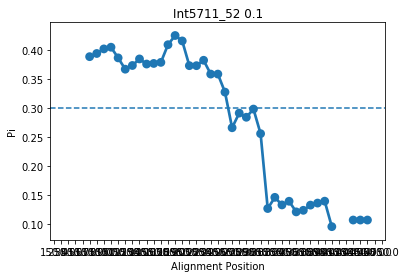

In [9]:
#ALL TOGETHER NOW 
clade='Int5711_52'
max_missing=0.1 

#calculate gene wide stat 
whole_res=whole_aln(clade, max_missing)
print(whole_res)
pi=whole_res["Pi_raw"]/whole_res['lseff']

#calculate sliding window 
window_result=sliding_window(clade, max_missing, 300, 100)

#plot 
dat=window_result[['clade', 'start', 'end', 'lseff', 'Pi_raw', 'D']]
dat['Pi']=dat['Pi_raw']/dat['lseff']
dat['midpoint']=dat['start']+150
    
sns.pointplot(data=dat, x="midpoint", y="Pi").set_title(clade+' '+str(max_missing))
plt.xlabel('Alignment Position')
plt.axhline(pi, ls='--')
plt.show()

Test how varying `max_missing` changes the estimated Pi value from both clades

In [10]:
#test different max missing on whole aln values of RPPC and Int5711_52 
clade='Int5711_52'
var=pd.DataFrame()
for i in np.arange(0, 0.55, 0.1):
    whole_res=whole_aln(clade, i)
    pi=whole_res["Pi_raw"]/whole_res['lseff']
    lseff=whole_res['lseff']
    var=var.append({'clade':clade, 'max_missing':i, 'Pi':pi, 'lseff':lseff}, ignore_index=True)
    
clade='RppC-like'
for i in np.arange(0, 0.55, 0.1):
    whole_res=whole_aln(clade, i)
    
    if whole_res['lseff'] == 0:
        pi=np.nan
    else:
        pi=whole_res["Pi_raw"]/whole_res['lseff']

    var=var.append({'clade':clade, 'max_missing':i, 'Pi':pi, 'lseff':whole_res['lseff']}, ignore_index=True)    
var

,Pi,clade,lseff,max_missing
0,0.278415,Int5711_52,577.0,0.0
1,0.299687,Int5711_52,1117.0,0.1
2,0.300674,Int5711_52,1352.0,0.2
3,0.298244,Int5711_52,1512.0,0.3
4,0.292955,Int5711_52,1657.0,0.4
5,0.265679,Int5711_52,1912.0,0.5
6,NaN,RppC-like,0.0,0.0
7,NaN,RppC-like,0.0,0.1
8,NaN,RppC-like,0.0,0.2
9,0.568509,RppC-like,20.0,0.3


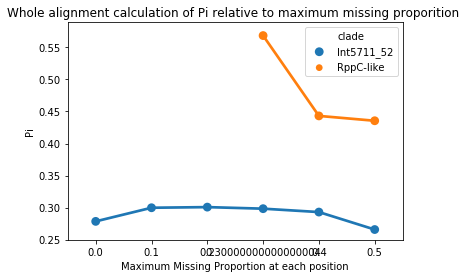

In [11]:
sns.pointplot(data=var, x="max_missing", y="Pi", hue='clade').set_title('Whole alignment calculation of Pi relative to maximum missing proporition ')
plt.xlabel('Maximum Missing Proportion at each position')
plt.show()

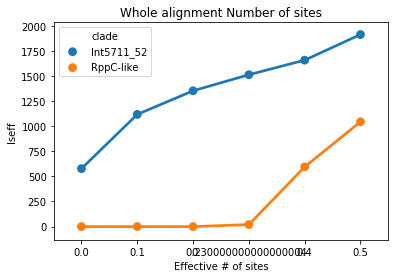

In [12]:
sns.pointplot(data=var, x="max_missing", y="lseff", hue='clade').set_title('Whole alignment Number of sites')
plt.xlabel('Effective # of sites')
plt.show()

Extend to across window 

In [13]:
#Calculate over windows at different max_missing values
clade='Int5711_52'
var=pd.DataFrame(columns=['D', 'Pi_raw', 'clade', 'end', 'lseff', 'start', 'max_missing'])
for i in np.arange(0, 0.55, 0.1):
    res=sliding_window(clade, i, 300, 100)
    res['max_missing']=i
    var=pd.concat([var, res])

    
var

Int5711_52
Int5711_52
Int5711_52
Int5711_52
Int5711_52
Int5711_52


,D,Pi_raw,clade,end,lseff,start,max_missing
0,NaN,NaN,Int5711_52,300.0,0.0,0.0,0.0
1,NaN,NaN,Int5711_52,400.0,0.0,100.0,0.0
2,NaN,NaN,Int5711_52,500.0,0.0,200.0,0.0
3,NaN,NaN,Int5711_52,600.0,0.0,300.0,0.0
4,NaN,NaN,Int5711_52,700.0,0.0,400.0,0.0
...,...,...,...,...,...,...,...
42,-0.289824,10.605856,Int5711_52,4500.0,59.0,4200.0,0.5
43,-0.170529,19.272364,Int5711_52,4600.0,95.0,4300.0,0.5
44,-0.456514,28.167938,Int5711_52,4700.0,147.0,4400.0,0.5
45,-0.594718,17.562083,Int5711_52,4800.0,88.0,4500.0,0.5


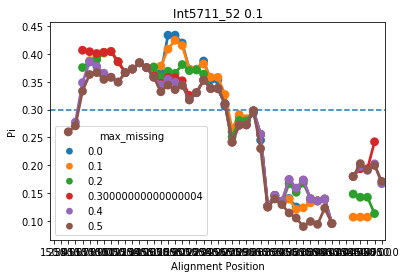

In [70]:
dat=var[['clade', 'start', 'end', 'lseff', 'Pi_raw', 'D', 'max_missing']]
dat['Pi']=dat['Pi_raw']/dat['lseff']
dat['midpoint']=dat['start']+150
    
sns.pointplot(data=dat, x="midpoint", y="Pi", hue='max_missing').set_title(clade)
plt.xlabel('Alignment Position')
plot.axhline(0.3, ls='--')

In [14]:
clade='RppC-like'
var=pd.DataFrame(columns=['D', 'Pi_raw', 'clade', 'end', 'lseff', 'start', 'max_missing'])
for i in np.arange(0.2, 0.55, 0.1):
    res=sliding_window(clade, i, 300, 100)
    res['max_missing']=i
    var=pd.concat([var, res])

    
var

#dat=var[['clade', 'start', 'end', 'lseff', 'Pi_raw', 'D', 'max_missing']]
#dat['Pi']=dat['Pi_raw']/dat['lseff']
#dat['midpoint']=dat['start']+150
    
#sns.pointplot(data=dat, x="midpoint", y="Pi", hue='max_missing').set_title(clade)
#plt.xlabel('Alignment Position')
#plot.axhline(0.3, ls='--')

RppC-like
RppC-like
RppC-like
RppC-like


,D,Pi_raw,clade,end,lseff,start,max_missing
0,NaN,NaN,RppC-like,300.0,0.0,0.0,0.2
1,NaN,NaN,RppC-like,400.0,0.0,100.0,0.2
2,NaN,NaN,RppC-like,500.0,0.0,200.0,0.2
3,NaN,NaN,RppC-like,600.0,0.0,300.0,0.2
4,NaN,NaN,RppC-like,700.0,0.0,400.0,0.2
...,...,...,...,...,...,...,...
168,NaN,NaN,RppC-like,17100.0,0.0,16800.0,0.5
169,NaN,NaN,RppC-like,17200.0,0.0,16900.0,0.5
170,NaN,NaN,RppC-like,17300.0,0.0,17000.0,0.5
171,NaN,NaN,RppC-like,17400.0,0.0,17100.0,0.5


Text(0.5, 1.0, 'RppC-like')

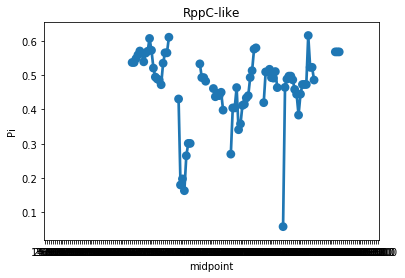

In [55]:
dat=var[['clade', 'start', 'end', 'lseff', 'Pi_raw', 'D', 'max_missing']]
dat['Pi']=dat['Pi_raw']/dat['lseff']
dat['midpoint']=dat['start']+150
#print(dat['Pi'])

dat['midpoint']
max(dat['midpoint'])
dat['Pi'].max()

dat
sns.pointplot(data=dat.loc[dat['max_missing']>0.41], x="midpoint", y="Pi").set_title(clade)
#plt.xlabel('Alignment Position')

Text(0.5, 1.0, 'RppC-like')

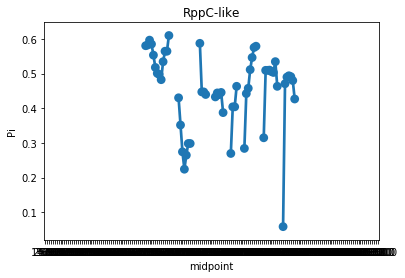

In [59]:
#dat[dat['max_missing']==0.5]
sns.pointplot(data=dat.loc[(dat['max_missing']<0.41) & (dat['max_missing']>0.31)], x="midpoint", y="Pi").set_title(clade)
